# Removing watermarks from the first 150 images
## StegaStamp Algorithm

### Main components
- **Encoder**

    The encoder is trained to embed a message into an image while minimizing perceptual differences between the input and encoded images.

    The architecture includes a U-Net style architecture that receives a four channel 400 × 400 pixel input (input image RGB channels plus one for the message) and outputs a three channel RGB residual image. The input message is represented as a **100** bit binary string, processed through a fully connected layer to form a 50 × 50 × 3 tensor, then upsampled to produce a 400 × 400 × 3 tensor.

- **Decoder**

    The decoder is a network trained to recover the hidden message from the encoded image. A spatial transformer network is used to develop robustness against small perspective changes that are introduced while capturing and rectifying the encoded image. The transformed image is fed through a series of convolutional and dense layers and a sigmoid to produce a final output with the same length as the message. The decoder network is supervised using cross entropy loss.

### Training Details

Training Data: MIRFLICKR dataset with randomly sampled binary messages.

Loss is the weighted sum of these loss components:

1) L2 residual regularization

2) the LPIPS perceptual loss

3) Сritic loss calculated between the encoded image and the original image

4) Сross entropy loss LM for the message

## Cloning WAVES benchmark

In [1]:
!git clone https://github.com/umd-huang-lab/WAVES.git
%cd WAVES/

Cloning into 'WAVES'...
remote: Enumerating objects: 278, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 278 (delta 2), reused 2 (delta 2), pack-reused 265 (from 1)
Receiving objects: 100% (278/278), 27.49 MiB | 10.40 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Filtering content: 100% (41/41), 810.19 MiB | 41.23 MiB/s, done.
/content/WAVES


In [ ]:
!bash shell_scripts/install_dependencies.sh

## Imports & Functions

In [ ]:
import os
from typing import List

import click
import torch
import numpy as np
import onnxruntime as ort
import torch.multiprocessing as mp
from PIL import Image, ImageOps
import warnings
from tqdm.auto import tqdm
from torchvision import transforms
import dotenv
import matplotlib.pyplot as plt
from dev import (
    LIMIT,
    SUBSET_LIMIT,
    WATERMARK_METHODS,
    check_file_existence,
    existence_operation,
    existence_to_indices,
    parse_image_dir_path,
    save_json,
    load_json,
    encode_array_to_string,
)

dotenv.load_dotenv(override=False)
warnings.filterwarnings("ignore")


In [ ]:
# code from https://github.com/umd-huang-lab/WAVES/blob/main/scripts/decode.py
def init_model(mode: str = "stable_sig",
               gpu: int = 1):
    if mode == "tree_ring":
        size = 64
        radius = 10
        channel = 3
        mask = torch.zeros((1, 4, size, size), dtype=torch.bool)
        x0 = y0 = size // 2
        y, x = np.ogrid[:size, :size]
        y = y[::-1]
        mask[:, channel] = torch.tensor(((x - x0) ** 2 + (y - y0) ** 2) <= radius**2)
        return mask
    elif mode == "stable_sig":
        session_options = ort.SessionOptions()
        session_options.intra_op_num_threads = 1
        session_options.inter_op_num_threads = 1
        session_options.log_severity_level = 3
        return ort.InferenceSession(
            os.path.join("decoders", "stable_signature.onnx"),
            providers=["CUDAExecutionProvider"],
            provider_options=[{"device_id": str(gpu)}],
            sess_options=session_options,
        )
    elif mode == "stegastamp":
        session_options = ort.SessionOptions()
        session_options.intra_op_num_threads = 1
        session_options.inter_op_num_threads = 1
        session_options.log_severity_level = 3
        return ort.InferenceSession(
            os.path.join("decoders", "stega_stamp.onnx"),
            providers=["CUDAExecutionProvider"],
            provider_options=[{"device_id": str(gpu)}],
            sess_options=session_options,
        )


def load_files(mode: str = "stable_sig",
               path: str = "Neurips24_ETI_BeigeBox",
               files_len: int = 1):
    if mode == "tree_ring":
        return torch.cat(
            [
                torch.load(
                    os.path.join(path, f"{idx}_reversed.pkl"), map_location="cpu"
                )
                for idx in range(files_len)
            ],
            dim=0,
        )
    elif mode == "stable_sig":
        return np.stack(
            [
                (
                    (
                        np.array(
                            Image.open(os.path.join(path, f"{idx}.png")),
                            dtype=np.float32,
                        )
                        / 255.0
                        - [0.485, 0.456, 0.406]
                    )
                    / [0.229, 0.224, 0.225]
                )
                .transpose((2, 0, 1))
                .astype(np.float32)
                for idx in range(files_len)
            ],
            axis=0,
        )
    elif mode == "stegastamp":
        return np.stack(
            [
                np.array(
                    ImageOps.fit(
                        Image.open(os.path.join(path, f"{idx}.png")), (400, 400)
                    ),
                    dtype=np.float32,
                )
                / 255.0
                for idx in range(files_len)
            ],
            axis=0,
        )


def decode(inputs: List[int],
           mode: str = "stable_sig",
           gpu: int = 1):
    model = init_model(mode, gpu)
    if mode == "tree_ring":
        fft_latents = torch.fft.fftshift(
            torch.fft.fft2(inputs.to(f"cuda:{gpu}")), dim=(-1, -2)
        )
        messages = torch.stack(
            [
                fft_latents[i].unsqueeze(0)[model].flatten()
                for i in range(fft_latents.shape[0])
            ],
            dim=0,
        )
        return torch.concatenate([messages.real, messages.imag], dim=1).cpu().numpy()
    elif mode == "stable_sig":
        outputs = model.run(
            None,
            {
                "image": inputs,
            },
        )
        return (outputs[0] > 0).astype(bool)
    elif mode == "stegastamp":
        outputs = model.run(
            None,
            {
                "image": inputs,
                "secret": np.zeros((inputs.shape[0], 100), dtype=np.float32),
            },
        )
        return outputs[2].astype(bool)


def encode(np_imgs, secrets):
    model = init_model(mode="stegastamp", gpu=1)

    wm_img, _ = model.run(
        output_names=['stegastamp', 'residual'],
        input_feed={'image': np_imgs, 'secret': secrets.astype(np.float32)}
    )

    return np_imgs, torch.tensor(wm_img).permute(0, 3, 1, 2)


def plot_results(output1, output2):
    fig, axs = plt.subplots(1, 2, figsize=(7, 3))
    axs[0].imshow(output1[0])
    axs[0].set_title('Original image')
    axs[0].axis('off')
    axs[1].imshow(output2[0].permute(1, 2, 0))
    axs[1].set_title('Original image + inverted watermark')
    axs[1].axis('off')
    plt.tight_layout()
    plt.show()

## Performing watermark overwriting attack

In [8]:
inputs = load_files(mode="stegastamp", path="Neurips24_ETI_BeigeBox", files_len=1)

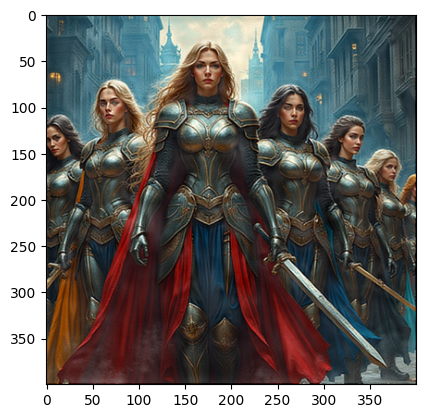

In [9]:
plt.imshow(inputs[0])
plt.show()

In [10]:
watermarks = decode(inputs=inputs, mode="stegastamp", gpu=1)
watermarks[0].astype(int)

array([0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1])

In [11]:
inverted_mask = 1 - watermarks.astype(int)
inverted_mask

array([[1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
        0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0]])

In [12]:
watermarks[0].shape # 100 bit message

(100,)

In [13]:
inputs.shape

(1, 400, 400, 3)

In [16]:
output1, output2 = encode(inputs, inverted_mask)

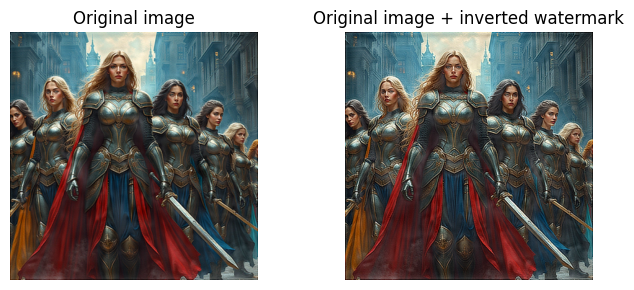

In [18]:
plot_results(output1, output2)

In [ ]:
# only first 150 original images from competitions
files_len = 150
inputs = load_files(mode="stegastamp", path="Neurips24_ETI_BeigeBox", files_len=files_len)

In [ ]:
DIR_SOURCE = "Neurips24_ETI_BeigeBox"
files = os.listdir(DIR_SOURCE)
sorted_files = sorted(files, key=lambda x: int(x.split('.')[0]))

new_dir = "Neurips24_ETI_BeigeBox_stegastamp"
os.makedirs(new_dir, exist_ok=True)

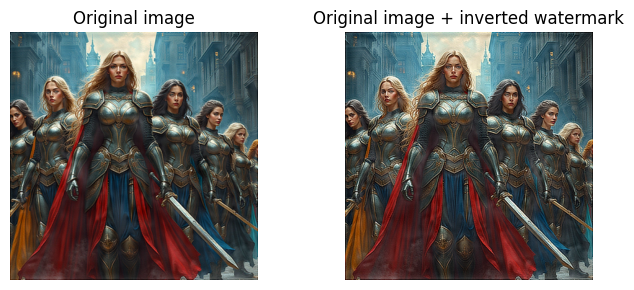

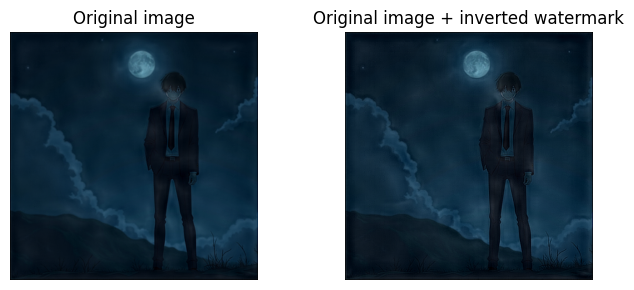

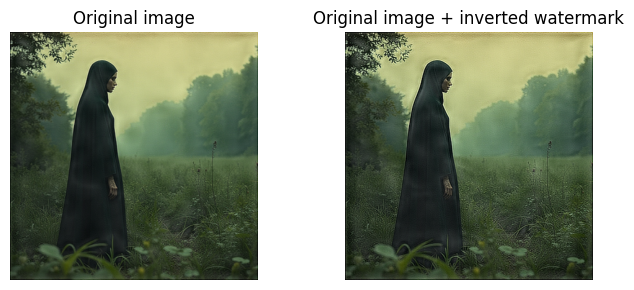

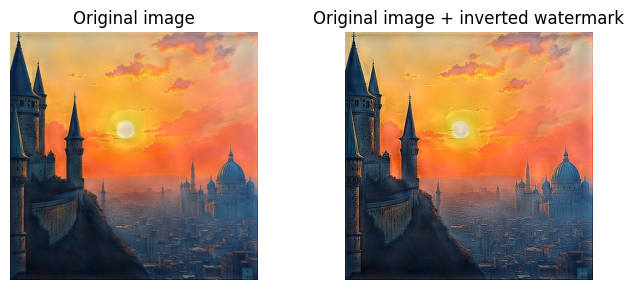

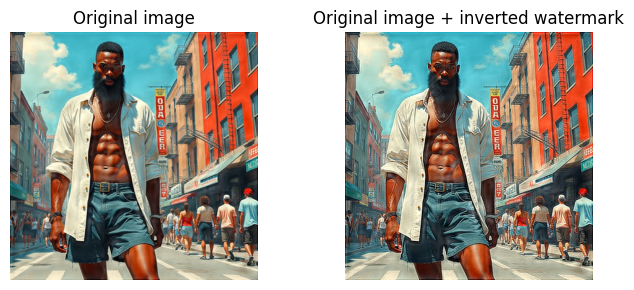

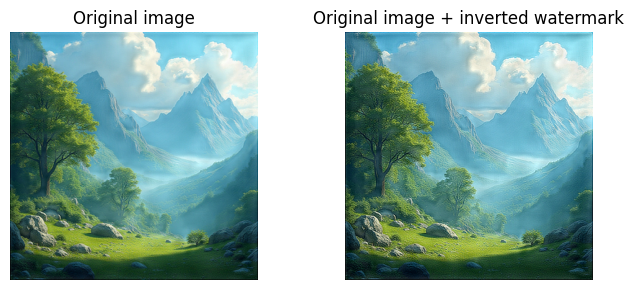

In [ ]:
for idx, (name_, input_img) in enumerate(zip(sorted_files[:files_len], inputs)):
    if name_.split('.')[-1] != 'png':
        print("Wrong file: ", name_)
        continue

    expanded_input_img = np.expand_dims(inputs[idx], axis=0)
    watermark = decode(inputs=expanded_input_img, mode="stegastamp", gpu=1)
    inverted_mask = 1 - watermarks.astype(int)

    orig_img, orig_img_wm = encode(expanded_input_img, inverted_mask)
    output_array = orig_img_wm[0].permute(1, 2, 0).detach().cpu().numpy()
    clip_img = orig_img_wm[0]
    clip_img = transforms.ToPILImage()(clip_img.cpu())
    resize_transform = transforms.Resize((512, 512))
    clip_img = resize_transform(clip_img)
    clip_img.save(f"{new_dir}/{idx}.png")

    if idx % 25 == 0:
        plot_results(orig_img, orig_img_wm)

In [ ]:
# if gpu performance is good

# files_len = 150
# inputs = load_files(mode="stegastamp", path="Neurips24_ETI_BeigeBox", files_len=files_len)
# watermarks = decode(inputs=inputs, mode="stegastamp", gpu=1)
# inverted_masks = 1 - watermarks.astype(int)
# _, outputs = encode(inputs, inverted_masks)

# os.makedirs("new", exist_ok=True)

# for idx, output_tensor in enumerate(outputs):
#     output_array = output_tensor.permute(1, 2, 0).detach().cpu().numpy()
#     output_array = (output_array * 255).astype(np.uint8)
#     image = Image.fromarray(output_array)
#     image.save(f"new/{idx}_inv.png")